# Embedded Languages via Overloading

Suppose you are creating a Python library for building logical circuits. You would like programmers to be able to build circuits that correspond to more complex, high-level functions (*e.g.*, from equality of bit vectors to entire hashing functions). How should you approach this task? What are the right abstractions? How can you minimize the amount of extra effort programmers must put into learning your library and its various interfaces?

Python's operator overloading features are not just a way to add syntactic convenience to your data structures. By leveraging this feature in the right way, you can greatly reduce the *conceptual* complexity of a solution by allowing programmers to use the skills they already possess. This article reviews a use case that demonstrates the value of recasting a solution as an *embedded language* within the Python syntax.

## Operator Overloading

Python allows programmers to change the meaning of some of its syntactic constructs when these constructs are applied to objects of programmer-defined classes (the definition of Python's syntax is discussed in more detail in a [previous article](https://python.supply/analyzing-and-transforming-abstract-syntax)). Programmers can do so by defining [special methods](https://docs.python.org/3/reference/datamodel.html) within a class definition. When the Python interpreter sees a certain operator (such as `+`) being applied to objects of a class that has such a special method defined (such as [`__add__`](https://docs.python.org/3/reference/datamodel.html#object.__add__)), the interpreter will invoke that method.

In the example below, the class `vector` allows users to build objects that represent two-dimensional vectors. The class definition has a method [`__eq__`](https://docs.python.org/3/reference/datamodel.html#object.__eq__).

In [1]:
class vector():
    def __init__(self, *coordinates):
        self.coordinates = coordinates

    def __eq__(self, other):
        return self.coordinates == other.coordinates

The method `__eq__` is invoked when two `vector` objects are supplied to the infix `==` operator.

In [1]:
v = vector(1,2)
w = vector(3,4)
(v == w, v == v)

(False, True)

## Embedded Language for Boolean Circuits

An *embedded language* is a specified subset of an existing programming language (which can be called the *host* language) that serves some distinct purpose. An important benefit of embedded languages is that they reuse the existing features of the host language, which can save both implementation effort and the barrier to entry for users of the embedded language.

Returning to the motivating use case of implementing a library for logical circuits, you might consider that a Python programmer using your library *already knows how to use Python to implement a logical circuit*. Therefore, any effort the programmer spends learning to use your library is potentially wasted. How might such a programmer implement a circuit they want to evaluate on inputs?

For the purposes of this example, assume that the programmer represents bits using the Python integers `0` and `1`. One approach the programmer might use is to define a function that operates on integers and uses Python's built-in logical operators on integer values.

In [1]:
def equal(x, y):
    return (x & y) | ((1 - x) & (1 - y))

Below are two approaches a Python programmer might use (the first being an imperative style and the second being a functional style) to implement an equality function `equals` for *bit vectors* using the equality function `equal` for bits that is defined above. You would like your circuit library to accommodate all of these different approaches (because these approaches reflect different trade-offs that might be suitable for different use cases, or simply because programmers might have different preferences or levels of experience with Python).

In [1]:
def equals(xs, ys):
    z = 1
    for i in range(len(xs)):
        z = z & equal(xs[i], ys[i])
    return z

def equals(xs, ys):
    from functools import reduce
    es = [equal(x, y) for (x, y) in zip(xs, ys)]
    return reduce((lambda e0, e1: e0 & e1), es)

Under its usual interpretation in Python (*i.e.*, when it is applied to lists of integers), the `equals` function can be used to determine the equality of bit vectors of equal length.

In [1]:
equals([0,1,1], [0,1,1])

1

Using overloading, it is possible to provide new definitions for the built-in `&`, `|` and `-` operators that *programmers already used* to define the `equal` and `equals` functions. The `circuit` class definition below includes the [`__or__`](https://docs.python.org/3/reference/datamodel.html#object.__or__), [`__and__`](https://docs.python.org/3/reference/datamodel.html#object.__and__), and [`__rsub__`](https://docs.python.org/3/reference/datamodel.html#object.__rsub__) methods that correspond to the way in which these three infix operators are used.

In [1]:
class circuit():
    def __init__(self, op='bit', args=None):
        self.op = op
        self.args = [] if args is None else args

    def __or__(self, other):
        return circuit('or', [self, other])

    def __and__(self, other):
        return circuit('and', [self, other])

    def __rsub__(self, other):
        if not isinstance(other, int) or other != 1:
            raise ValueError('can only subtract from 1')
        return circuit('not', [self])

    def __repr__(self):
        return 'circuit("' + self.op + '", ' + str(self.args) + ')'

    def __str__(self):
        return self.__repr__()

To make it easier to see the circuits after they have been constructed, the definition above also includes a recursive [`__repr__`](https://docs.python.org/3/reference/datamodel.html#object.__repr__) method and an equivalent [`__str__`](https://docs.python.org/3/reference/datamodel.html#object.__str__) method. The first method is invoked when Python attempts to display an object of the class (*e.g.*, in an interactive prompt) and the second is invoked when the built-in Python [`str`](https://docs.python.org/3/library/stdtypes.html#str) function is applied to an object of the class `circuit`.

A programmer can now build a circuit using familiar infix operators. The only difference is that instead of using Python integers to represent the bits that constitute the inputs (*i.e.*, base cases), programmers can use `circuit` objects that represent bit constants.

In [1]:
c0 = circuit("bit", 0)
c1 = circuit("bit", 1)
c2 = 1 - (c0 & c1)

More importantly, programmers can now *reuse without modification* the equality functions that have already been defined. However, those same functions now generate entire equality circuits (rather than only computing the result of evaluating those circuits).

In [1]:
equal(c1, c2)

circuit("or", [circuit("and", [circuit("bit", 1), circuit("not", [circuit("and", [circuit("bit", 0), circuit("bit", 1)])])]), circuit("and", [circuit("not", [circuit("bit", 1)]), circuit("not", [circuit("not", [circuit("and", [circuit("bit", 0), circuit("bit", 1)])])])])])

Even the more complex `equals` method works seamlessly whether it is given lists of bit vectors or lists of base case circuits.

In [1]:
equals([c0, c1], [c0, c1])

circuit("and", [circuit("or", [circuit("and", [circuit("bit", 0), circuit("bit", 0)]), circuit("and", [circuit("not", [circuit("bit", 0)]), circuit("not", [circuit("bit", 0)])])]), circuit("or", [circuit("and", [circuit("bit", 1), circuit("bit", 1)]), circuit("and", [circuit("not", [circuit("bit", 1)]), circuit("not", [circuit("bit", 1)])])])])

## Portable or Specialized Embeddings via Inheritance

The advantage of the definition of `circuit` in the section above is that programmers can *build* new circuits using existing built-in Python operators. However, in order to *inspect* or *traverse* the circuit data structure, programmers must become familiar with your class definition. Using [inheritance](https://docs.python.org/3/tutorial/classes.html#inheritance), you can address this second obstacle.

The variant of the `circuit` class below represents circuits as dictionaries (or, more precisely, as objects of classes that inherit all the features of dictionaries).

In [1]:
class circuit(dict):
    def __or__(self, other):
        return circuit({'or': [self, other]})

    def __and__(self, other):
        return circuit({'and': [self, other]})

    def __rsub__(self, other):
        if not isinstance(other, int) or other != 1:
            raise ValueError('can only subtract from 1')
        return circuit({'not': [self]})

Because circuits built by programmers are now also dictionaries, it is easier to use existing built-in libraries to perform common operations. For example, a formatted JSON string representation of a circuit can be emitted using the [json](https://docs.python.org/3/library/json.html) library. In the example below, a JSON representation of the bit vector equality circuit is constructed.

In [1]:
c0 = circuit({"bit": 0})
c1 = circuit({"bit": 1})
import json
print(json.dumps(equals([c0, c1], [c0, c1])))

{"and": [{"or": [{"and": [{"bit": 0}, {"bit": 0}]}, {"and": [{"not": [{"bit": 0}]}, {"not": [{"bit": 0}]}]}]}, {"or": [{"and": [{"bit": 1}, {"bit": 1}]}, {"and": [{"not": [{"bit": 1}]}, {"not": [{"bit": 1}]}]}]}]}


For another example of this approach that is more specialized, consider the `circuit` class below that is derived from the [`Graph`](https://networkx.org/documentation/networkx-1.7/reference/classes.graph.html) class in the [NetworkX](https://networkx.org) library. In this implementation, each `circuit` object is a graph in which nodes correspond to base cases or operations and edges connect operation nodes with their operands. The method corresponding to a binary operator such as `&` performs the following steps:

* it accepts two input graphs (each representing an entire circuit, with the output node as the first entry in its node list),
* it combines these two graphs into a new graph in which each node's name is extended to reflect the path to that node,
* it adds a new node corresponding to the binary operation, and
* it adds edges between this new output node and the root nodes of the two input graphs.

Note that in order to have mathematical notation within the node labels in the final rendering of the circuit, the [LaTeX](https://en.wikipedia.org/wiki/LaTeX) notation is used for the operator name strings.

In [1]:
from networkx import Graph, union

class circuit(Graph):
    def __init__(self, arg=None):
        Graph.__init__(self)
        if arg is not None:
            self.add_nodes_from([str(arg)])

    def __or__(self, other):
        c = union(
            circuit("$\\vee$"),
            union(self, other, rename=("l-", "r-"))
        )
        c.add_edges_from([
            ("$\\vee$", "l-" + list(self.nodes)[0]),
            ("$\\vee$", "r-" + list(other.nodes)[0])
        ])
        return c

    def __and__(self, other):
        c = union(
            circuit("$\\wedge$"),
            union(self, other, rename=("l-", "r-"))
        )
        c.add_edges_from([
            ("$\\wedge$", "l-" + list(self.nodes)[0]),
            ("$\\wedge$", "r-" + list(other.nodes)[0])
        ])
        return c

    def __rsub__(self, other):
        if not isinstance(other, int) or other != 1:
            raise ValueError('can only subtract from 1')
        c = union(circuit("$\\neg$"), self, rename=("", "n-"))
        c.add_edges_from([("$\\neg$", "n-"+list(self.nodes)[0])])
        return c

This approach makes it possible to render a graph diagram directly from a `circuit` object using the NetworkX library. To demonstrate how a programmer can accomplish this, consider the following circuit `c` built using the original `equals` method (note that it has been unmodified and yet works with objects of the newest variant of `circuit`).

In [1]:
c = equals(
    [circuit('$x_0$'), circuit('$x_1$')], 
    [circuit('$y_0$'), circuit('$y_1$')]
)

Because `c` inherits all the features of a NetworkX `Graph` object, a programmer can inspect its nodes and edges. In the example below, the last three nodes and the number of edges in the circuit graph are extracted. Notice that each node name is a string that describes the path to that node from the circuit's overall output node (with `'l'` and `'r'` representing left-hand and right-hand subgraphs, respectively).

In [1]:
(list(c.nodes)[-3:], len(c.edges))

(['r-r-l-n-$x_1$', 'r-r-r-$\\neg$', 'r-r-r-n-$y_1$'], 18)

The following function is convenient for rendering the graph. It takes a node name string, splits it into its constituent parts (representing the path from the output node), and calculates a horizontal and vertical coordinate for that node.

In [1]:
def position(n):
    # Generate coordinates based on the path
    # encoded in the node name.
    x = sum(
        {'l':-1, 'r':1}.get(c, 0)/(2**(i+3)) 
        for (i, c) in enumerate(n.split('-'))
    )
    y = n.count('-')/8
    return (x, y)

With the help of the position function, rendering the circuit `c` as a graph is straightforward using the [`draw_networkx`](https://networkx.org/documentation/latest/reference/generated/networkx.drawing.nx_pylab.draw_networkx) function. The positions for the rendered nodes are specified by building a dictionary using `position` and the labels for the rendered nodes are obtained by taking the last component of the node names in `c`.

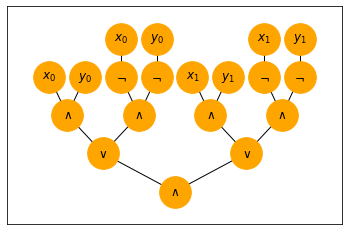

In [1]:
from networkx import draw_networkx
draw_networkx(
    c,
    pos=dict((n, position(n)) for n in c.nodes),
    labels=dict((n, n.split('-')[-1]) for n in c.nodes),
    node_size=1000,
    node_color="orange"
)

# Further Reading

This article presented a brief overview of [operator overloading in Python](https://docs.python.org/3/reference/datamodel.html#special-method-names), with a motivating example involving a number of [embedded domain-specific languages](https://en.wikipedia.org/wiki/Domain-specific_language#External_and_Embedded_Domain_Specific_Languages) for defining circuits. A Python library that addresses exactly the same circuit construction use case considered in this article is [circuitry](https://pypi.org/project/circuitry/), which defines an embedded language for constructing circuits as defined in the [circuit](https://pypi.org/project/circuit/) library. Other examples of feature-rich and widely used domain-specific languages embedded inside Python include the [Django](https://www.djangoproject.com/) web framework and the [pandas](https://pandas.pydata.org/) data analysis library. However, even small built-in libraries such as [typing](https://docs.python.org/3/library/typing.html) use operator overloading to provide a more streamlined experience for programmers.

Many other programming languages support some form of [operator overloading](https://en.wikipedia.org/wiki/Operator_overloading), as well as the introduction of custom infix, prefix, and even postfix operators. [Some languages](https://en.wikipedia.org/wiki/Operator_overloading#Catalog) have both of these features. A more general term for the operator overloading capability is [*ad hoc polymorphism*](https://en.wikipedia.org/wiki/Ad_hoc_polymorphism): the ability to provide multiple definitions for the same syntactic construct (with either the interpreter or compiler determining which definition to use based on the types of the inputs). Other, distinct types of polymorphism exist as well, such as [*parametric polymorphism*](https://en.wikipedia.org/wiki/Parametric_polymorphism): the ability to apply exactly the same function (having the same syntactic definition) to arguments of different types. You might notice that the definitions of `equal` and `equals` in this article are actually examples of parametric polymorphism.